Targetless Subtraction of Bi-linear Noise in LIGO O3 Data
==========================================================

In this example, we will do a simple regression problem where unwanted bilinear noise is added to the desired output signal as follows

\begin{align}
n_1(t) &= \sin(2\pi f_{n_1} t)\\
n_2(t) &= \sin(2\pi f_{n_2} t + \phi)\\
d(t) &= \text{true}(t) + An_1(t)*n_2(t) + Bn_2(t)
\end{align}

The noise we end up introducing will be bilinear and will occur at the beat frequencies between the coupled noise sources, e.g., at

\begin{equation}
  f_{obs} = f_{n_1} \pm f_{n_2}
\end{equation}

Therefore one frequency is driving (modulating) the other. From the target data alone, it would be impossible to know if these "sidebands" are linear, bilinear, or of higher order. In the case of LIGO data, we have around a hundred thousand witness channels. If we suspect bilinear noise, regressing blindly would mean running "$10^5$ pick $2$" or $\sim 1\times 10^{10}$ networks to run. At 10 minute training times per network, it would take around $10 \times 10^{10}/(5\times 10^5)\sim 2\times 10^5$ YEARS to remove the noise! Despite these awful stats, we will attempt to regress a bilinear noise source from real "O3" LIGO data.

It this case, a noise moving slowly (relatively speaking) at $\sim 0.5$ Hz is beating agaist the very prominent power lines (at $60$ Hz) creating sidebands at $60\pm 0.5$ Hz. We will see that we can subtract the sidebands, but cannot remove the 60 Hz power mains peak. This is due to a phase offset of the "MAINS" witness channel of $\sim 0.01$ seconds. This isn't much, but it's roughly half of a 60Hz cycle, so it is more than enough of a phase shift to go from subtracting noise to adding it. To address this, we will again add 'context' to the network, this time by employing the "lookback" of LSTM recurrent networks. 

In [11]:
# do imports
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(3301)
import scipy.signal as sig
import scipy.io as sio
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [12]:
# channel names
darm_chan = 'H1:GDS-CALIB_STRAIN'
pem_chan  = 'H1:PEM-CS_MAINSMON_EBAY_1_DQ'
asc_chans = ['H1:ASC-PRC1_Y_INMON',
             'H1:ASC-PRC2_P_INMON',
             'H1:ASC-SRC2_Y_INMON',
             'H1:ASC-DHARD_Y_INMON',
             'H1:ASC-INP1_P_INMON',
             'H1:ASC-INP1_Y_INMON',
             'H1:ASC-MICH_P_INMON',
             'H1:ASC-MICH_Y_INMON',
             'H1:ASC-PRC1_P_INMON',
             'H1:ASC-PRC2_Y_INMON',
             'H1:ASC-SRC1_P_INMON',
             'H1:ASC-SRC1_Y_INMON',
             'H1:ASC-SRC2_P_INMON',
             'H1:ASC-DHARD_P_INMON',
             'H1:ASC-CHARD_P_INMON',
             'H1:ASC-CHARD_Y_INMON',
             'H1:ASC-DSOFT_P_INMON',
             'H1:ASC-DSOFT_Y_INMON',
             'H1:ASC-CSOFT_P_INMON',
             'H1:ASC-CSOFT_Y_INMON']

In [13]:
# let global params
fs_fast, fs_slow, dur = 256, 16, 2048  # Sampling rates and segment duration
st = 1242457832  # GPS Start Time
et = st + dur
flow, fhigh = 56, 64  # frequency band of interest

We will want to band pass the target data. This will reduce the amount of data we need to train on and ensure a better regression result

In [14]:
def butter_filter(dataset,
                 low   = 4.0,
                 high  = 20.0,
                 order = 8,
                 btype = 'bandpass',
                 fs    = 512):
    """
    Phase preserving filter (bandpass, lowpass or highpass)
    based on a butterworth filter

    Parameters
    ----------
    dataset : `numpy.ndarray`
        input data (chans x lenght) where chan==0 is target
    lowcut : `float`
        low knee frequency
    highcut : `float`
        high knee frequency
    order : `int`
        filter order
    btype : `str`
        type of filter (bandpass, highpass, lowpass)
    fs : `int`
        sample rate

    Returns
    -------
    dataset : `numpy.ndarray`
        filtered dataset
    """

    # Normalize the frequencies
    nyq  = 0.5 * fs
    low  /= nyq
    high /= nyq

    # Make and apply filter
    if 'high' in btype:
        z, p, k = sig.butter(order, low, btype=btype, output='zpk')
    elif 'band' in btype:
        z, p, k = sig.butter(order, [low, high], btype=btype, output='zpk')
    elif 'low' in btype:
        z, p, k = sig.butter(order, high, btype=btype, output='zpk')
    sos = sig.zpk2sos(z, p, k)

    if dataset.ndim == 2:
        for i in range(dataset.shape[0]):
            dataset[i, :] = sig.sosfiltfilt(sos, dataset[i, :])
    else:
        dataset = sig.sosfiltfilt(sos, dataset)

    return dataset

In [15]:
# load the data and upsample the slow channels
darm = sio.loadmat('darm.mat')['data']
darm = darm.reshape(darm.shape[1])
darm = butter_filter(darm.flatten(), low=flow, high=fhigh, fs=fs_fast)

pem = sio.loadmat('pem.mat')['data']
pem = pem.reshape(pem.shape[1])

asc = sio.loadmat('asc.mat')['data']
asc = sig.resample(asc[1:5, :], dur*fs_fast, axis=1)  # let's just use 4 ASC channels instead of 20

Let's break for a moment and look at the power in a few of these channels

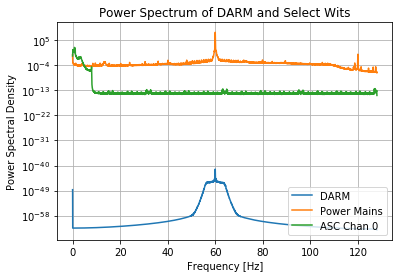

In [16]:
freqs, darm_psd = sig.welch(darm, fs=fs_fast, nperseg=fs_fast*60)
_, mains_psd = sig.welch(pem, fs=fs_fast, nperseg=fs_fast*60)
_, asc1_psd = sig.welch(asc[0 ,:], fs=fs_fast, nperseg=fs_fast*60)
plt.semilogy(freqs, darm_psd.flatten(), label='DARM')
plt.semilogy(freqs, mains_psd.flatten(), label='Power Mains')
plt.semilogy(freqs, asc1_psd.flatten(), label='ASC Chan 0')
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectrum of DARM and Select Wits')
plt.show()
plt.close()

We now have our first problem - the power in DARM is ~50 orders of magnitude below the power mains! If we try to train a network this way, we'd have to characterize the noise all the way down to the 50th decimal place. This is even below the round off error of the 32 bit floating point numbers we're using. To pull out the features we want, we can standardize each of the data streams by doing

\begin{equation}
  y := \frac{y - \mu}{\sigma}
\end{equation}

where $y$ is the data array, $\mu$ is the mean of that data array and $\sigma$ is the standard deviation. At this point, each data stream should have zero mean and a standard deviation of 1. 

In [17]:
darm = (darm - np.mean(darm))/np.std(darm)
pem = (pem - np.mean(pem))/np.std(pem)
for ix in range(asc.shape[0]):
    asc[ix, :] = (asc[ix, :] - np.mean(asc[ix, :])) / np.std(asc[ix, :])

wits = np.vstack((pem, asc))  # combine witnesses into a single matrix

Now let's check the power in the same channels again (NOTE: the ASC channels are sampled at 16Hz, so the PSD for these channels is meaningless above their Nyquist frequency of 8Hz)

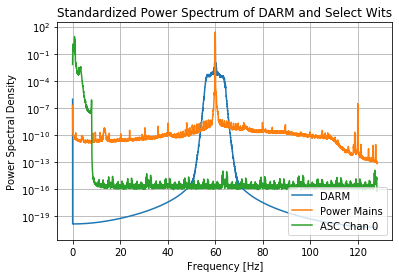

In [18]:
freqs, darm_psd = sig.welch(darm, fs=fs_fast, nperseg=fs_fast*60)
_, mains_psd = sig.welch(pem, fs=fs_fast, nperseg=fs_fast*60)
_, asc1_psd = sig.welch(asc[0 ,:], fs=fs_fast, nperseg=fs_fast*60)
plt.semilogy(freqs, darm_psd.flatten(), label='DARM')
plt.semilogy(freqs, mains_psd.flatten(), label='Power Mains')
plt.semilogy(freqs, asc1_psd.flatten(), label='ASC Chan 0')
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('Standardized Power Spectrum of DARM and Select Wits')
plt.show()
plt.close()

Great! The frequency band around 60Hz is now in a good position to be regressed by our witnesses. We will of course have to rescale in the end, but this is a simple matter.

We may now split the data into training and testing samples. We have a total of 2048 seconds of data, so lets use 1988s for training and test on the last 60 seconds.

In [19]:
test_dur = 60
tfrac = (2048-test_dur)*fs_fast
x_train = wits[:, :tfrac].T
y_train = darm[:tfrac]

x_test = wits[:, tfrac:].T
y_test = darm[tfrac:]

In [20]:
# Build and run the network
model = Sequential()
model.add(Dense(4, input_dim=wits.shape[0], activation='elu'))
model.add(Dense(4, activation='elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), batch_size=1000)

y_hat = model.predict(x_test).flatten()
clean = y_test - y_hat

Epoch 1/20
509/509 [==============================] - 5s 5ms/step - loss: 0.8712 - val_loss: 0.8017
Epoch 2/20
509/509 [==============================] - 1s 2ms/step - loss: 0.8239 - val_loss: 0.7975
Epoch 3/20
509/509 [==============================] - 1s 2ms/step - loss: 0.8100 - val_loss: 0.7958
Epoch 4/20
509/509 [==============================] - 1s 2ms/step - loss: 0.8115 - val_loss: 0.7952
Epoch 5/20
509/509 [==============================] - 1s 2ms/step - loss: 0.8111 - val_loss: 0.7950
Epoch 6/20
509/509 [==============================] - 1s 2ms/step - loss: 0.8096 - val_loss: 0.7949
Epoch 7/20
509/509 [==============================] - 1s 2ms/step - loss: 0.8074 - val_loss: 0.7947
Epoch 8/20
509/509 [==============================] - 1s 2ms/step - loss: 0.8136 - val_loss: 0.7949
Epoch 9/20
509/509 [==============================] - 1s 2ms/step - loss: 0.8127 - val_loss: 0.7947
Epoch 10/20
509/509 [==============================] - 1s 2ms/step - loss: 0.8084 - val_loss: 0.7946

Either we converged very quickly, or something isn't quite right. Let's make some more PSDs and see how we did

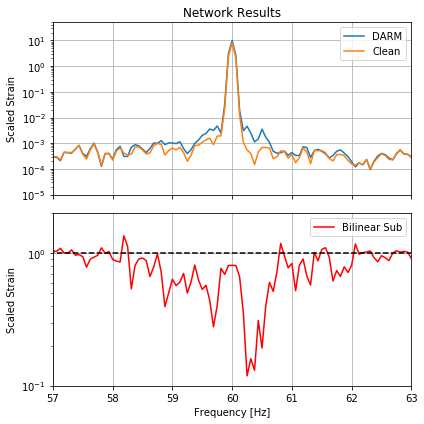

In [21]:
nps = fs_fast*16
freq, tar = sig.welch(y_test, fs=fs_fast, nperseg=nps)
_, cln = sig.welch(clean, fs=fs_fast, nperseg=nps)
cln = cln.reshape(len(freq))
tar = tar.reshape(len(freq))

fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(6, 6))
ax[0].semilogy(freq, tar, label='DARM')
ax[0].semilogy(freq, cln, label='Clean')
ax[0].set_title('Network Results')
ax[0].set_ylabel('Scaled Strain')
ax[0].set_ylim([1e-5, 5e1])
ax[0].set_xlim([flow+1, fhigh-1])
ax[0].legend()
ax[0].grid(True)

ax[1].semilogy(freq, cln/tar, label='Bilinear Sub', color='red', lw=1.5)
ax[1].semilogy(freq, np.ones(tar.size), ls='--', color='black')
ax[1].set_ylabel('Scaled Strain')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylim([1e-1, 2])
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()
plt.close()

Interesting! We seem to have (mostly) subtracted the sidebands but for some reason the 60Hz line is still there. If our activation function was strictly nonlinear, this could make sense, but we used `elu` which can be described as

\begin{equation}
  \text{elu}(x) = 
  \begin{cases}
    \alpha &x \leq 0 \\
    \alpha (e^x -1)  &x > 0
  \end{cases}
\end{equation}

Therefore (for negative inputs) we should be able to Taylor expand and get terms of any power of $x$, but then why isn't this happening? The power at 60 Hz far supersedes that of any other spectral feature, so naively we would expect to first remove the power lines and only then begin to remove other spectral features. To see why, let's look at the time series for a moment

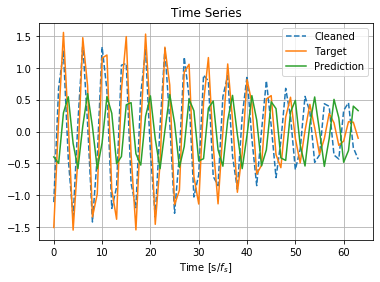

In [22]:
plt.plot(clean[-64:], label='Cleaned', ls='--')
plt.plot(y_test[-64:], label='Target')
plt.plot(y_hat[-64:], label='Prediction')
plt.legend()
plt.title('Time Series')
plt.xlabel('Time [s/$f_s$]')
plt.grid(True)
plt.show()
plt.close()

Remember that the power at 60 Hz dominaties, so that is basically all that we are seeing here. If you look closely, you will see that the phase of the prediction is not quite right - it is lagging behind a bit. It turns out that it is just 2-3 time steps aka $[2/256,\, 3/256] = [0.008, \, 0.01]$ seconds)

Again it seems as though we will need to include more context to successfully estimate the noise from the witness and target channels. Instead of using block input into a feedforward (Dense) network, let us this time use LSTMs. We will have to reshape the data to incorporate the lookback and feed in the correct shape to the LSTM network. Let's first write a lookback function

In [23]:
def do_lookback(data, steps=1, validation=False):
    """
    modify the dataset to include previous timesteps to feed into the
    recurrent network. this helps to capture long-term dependencies

    Parameters
    ----------
    data : `ndarray`
        numpy array containing the initial dataset
    steps : `int`
        number of previous time-steps to include
    validation : `bool`
        used for handling 1D arrays

    Returns
    -------
    temp : `ndarray`
        data array with added (previous) time-steps. if original array
        was M x N and L steps of lookback were requested, then the output
        is of shape M x L x N

    """
    temp = np.zeros((data.shape[0] - steps, steps + 1, data.shape[1]))
    temp[:, 0, :] = data[steps:, :]
    for i in range(temp.shape[0]):
        temp[i, 1:] = data[i:i + steps][::-1]

    if validation:
        temp = temp.reshape((temp.shape[0], temp.shape[1]))

    for i in range(temp.shape[0]):
        temp[i, :] = temp[i, :][::-1]

    return temp

In [24]:
# apply 8 steps of lookback (anything >= int(ceil(256/60)) should work)
wits = np.vstack((pem, asc))
lb = 8
darm_lb = darm[8:]
wits_lb = do_lookback(wits.T, 8)

# reshape for training and testing (samples, lookback, features)
tfrac = 60*fs_fast
x_train = wits_lb[:-tfrac, :, :]
y_train = darm_lb[:-tfrac]

x_test = wits_lb[-tfrac:, :, :]
y_test = darm_lb[-tfrac:]

In [25]:
# We can now run our first LSTM recurrent neural network!
model = Sequential()
model.add(LSTM(4, input_shape=(x_train.shape[1], x_train.shape[2]), activation='elu'))
# model.add(Dense(4, activation='elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), batch_size=1000)

Epoch 1/20
509/509 [==============================] - 7s 7ms/step - loss: 0.9446 - val_loss: 0.0372
Epoch 2/20
509/509 [==============================] - 4s 7ms/step - loss: 0.0172 - val_loss: 0.0080
Epoch 3/20
509/509 [==============================] - 3s 7ms/step - loss: 0.0174 - val_loss: 0.0056
Epoch 4/20
509/509 [==============================] - 3s 7ms/step - loss: 0.0085 - val_loss: 0.0048
Epoch 5/20
509/509 [==============================] - 3s 7ms/step - loss: 0.0125 - val_loss: 0.0045
Epoch 6/20
509/509 [==============================] - 3s 7ms/step - loss: 0.0122 - val_loss: 0.0043
Epoch 7/20
509/509 [==============================] - 3s 7ms/step - loss: 0.0130 - val_loss: 0.0042
Epoch 8/20
509/509 [==============================] - 3s 7ms/step - loss: 0.0117 - val_loss: 0.0042
Epoch 9/20
509/509 [==============================] - 4s 7ms/step - loss: 0.0141 - val_loss: 0.0042
Epoch 10/20
509/509 [==============================] - 3s 7ms/step - loss: 0.0135 - val_loss: 0.0043

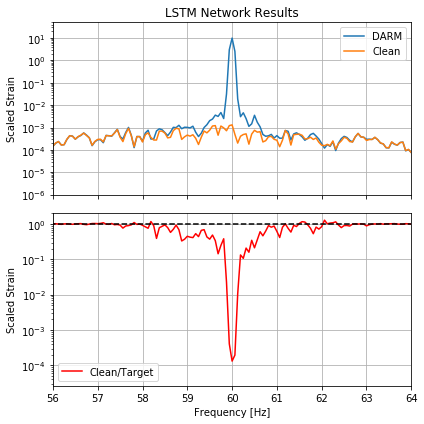

In [26]:
# make predictions and plots
y_hat = model.predict(x_test)
y_hat = y_hat.flatten()
clean = y_test - y_hat

nps = fs_fast*16
freq, tar = sig.welch(y_test, fs=fs_fast, nperseg=nps)
_, cln = sig.welch(clean, fs=fs_fast, nperseg=nps)
cln = cln.reshape(len(freq))
tar = tar.reshape(len(freq))

fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(6, 6))
ax[0].semilogy(freq, tar, label='DARM')
ax[0].semilogy(freq, cln, label='Clean')
ax[0].set_title('LSTM Network Results')
ax[0].set_ylabel('Scaled Strain')
ax[0].set_ylim([1e-6, 5e1])
ax[0].set_xlim([flow, fhigh])
ax[0].legend()
ax[0].grid(True)

ax[1].semilogy(freq, cln/tar, label='Clean/Target', color='red', lw=1.5)
ax[1].semilogy(freq, np.ones(tar.size), ls='--', color='black')
ax[1].set_ylabel('Scaled Strain')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylim([np.min(cln/tar)/5, 2])
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()
plt.close()

Now **this** is more like it! Not only have we removed the sidebands this time, but we have also removed the excess power from the electric lines (10^4 reduction!). 

LSTMs can be a great tool, but they are often difficult to train and the memory they use grows quickly. Each lookback step increase the data size by that factor - so by using a lookback of 8, we had to hold a dataset 8x bigger than in the feedforward network ($2048\times 256\times (8+1) = 4,718,592$ data points). Doing a full second of lookback would mean that just your dataset is ~4.3GB. You _also_ need to hold in memory the weights for each matrix, the backpropagated error, the value of each of the gates... 